<a href="https://colab.research.google.com/github/djberman87/Code_Execution/blob/Code_Execution/quickstarts/Code_Execution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2025 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Gemini API: Code Execution

<a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Code_Execution.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" height=30/></a>


The Gemini API [code execution](https://ai.google.dev/gemini-api/docs/code-execution) feature enables the model to generate and run Python code based on plain-text instructions that you give it, and even output graphs. It can learn iteratively from the results until it arrives at a final output.

This notebook is a walk through:
* Understanding how to start using the code execution feature with Gemini API
* Learning how to use code execution on single Gemini API calls
* Running scenarios using local files (or files uploaded to the Gemini File API) via File I/O
* Using code execution on chat interactions
* Performing code execution on multimodal scenarios

## Setup

### Install SDK

Install the SDK from [PyPI](https://github.com/googleapis/python-genai).

In [1]:
%pip install -q -U "google-genai>=1.0.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.2/261.2 kB 7.6 MB/s eta 0:00:00


### Setup your API key

To run the following cell, your API key must be stored it in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see [Authentication ![image](https://storage.googleapis.com/generativeai-downloads/images/colab_icon16.png)](../quickstarts/Authentication.ipynb) for an example.

In [3]:
from google.colab import userdata

GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')

### Initialize SDK client

With the new SDK you now only need to initialize a client with you API key (or OAuth if using [Vertex AI](https://cloud.google.com/vertex-ai)). The model is now set in each call.

In [4]:
from google import genai

client = genai.Client(api_key=GOOGLE_API_KEY)

### Choose a model

Now select the model you want to use in this guide, either by selecting one in the list or writing it down. Keep in mind that some models, like the 2.5 ones are thinking models and thus take slightly more time to respond (cf. [thinking notebook](./Get_started_thinking.ipynb) for more details and in particular learn how to switch the thiking off).

For more information about all Gemini models, check the [documentation](https://ai.google.dev/gemini-api/docs/models/gemini) for extended information on each of them.

In [5]:
MODEL_ID = "gemini-3-pro-preview" # @param ["gemini-2.5-flash-lite", "gemini-2.5-flash", "gemini-2.5-pro","gemini-3-pro-preview"] {"allow-input":true, isTemplate: true}

## Helper function

When using code execution as a tool, the model returns a list of parts including `text`, `executable_code`, `execution_result`, and `inline_data` parts. Use the function below to help you visualize and better display the code execution results. Here are a few details about the different fields of the results:

* `text`: Inline text generated by the model.
* `executable_code`: Code generated by the model that is meant to be executed.
* `code_execution_result`: Result of the `executable_code`.
* `inline_data`: Inline media generated by the model.

In [6]:
from IPython.display import Image, Markdown, Code, HTML

def display_code_execution_result(response):
  for part in response.candidates[0].content.parts:
    if part.text is not None:
      display(Markdown(part.text))
    if part.executable_code is not None:
      code_html = f'<pre style="background-color: green;">{part.executable_code.code}</pre>' # Change code color
      display(HTML(code_html))
    if part.code_execution_result is not None:
      display(Markdown(part.code_execution_result.output))
    if part.inline_data is not None:
      display(Image(data=part.inline_data.data, width=800, format="png"))
    display(Markdown("---"))

## Use `code_execution` with a single call

When initiating the model, pass `code_execution` as a `tool` to tell the model that it is allowed to generate and run code.

In [7]:
from google.genai import types

prompt = """
    What is the sum of the first 50 prime numbers?
    Generate and run code for the calculation, and make sure you get all 50.
"""

response = client.models.generate_content(
    model=MODEL_ID,
    contents=prompt,
    config=types.GenerateContentConfig(
        tools=[types.Tool(
            code_execution=types.ToolCodeExecution
            )]
        )
    )

display_code_execution_result(response)

---

Primes generated: [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97, 101, 103, 107, 109, 113, 127, 131, 137, 139, 149, 151, 157, 163, 167, 173, 179, 181, 191, 193, 197, 199, 211, 223, 227, 229]
Count: 50
Sum: 5117


---

The sum of the first 50 prime numbers is **5,117**.

Here are the numbers that were summed:
2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97, 101, 103, 107, 109, 113, 127, 131, 137, 139, 149, 151, 157, 163, 167, 173, 179, 181, 191, 193, 197, 199, 211, 223, 227, 229.

---

## Code execution with File I/O

The dataset you will use in this guide comes from the [StatLib](http://lib.stat.cmu.edu/datasets/) from the [Department of Statistics](https://www.cmu.edu/dietrich/statistics-datascience/index.html) at [Carnegie Mellon University](http://www.cmu.edu/). It is made available by the [`scikit-learn`](https://scikit-learn.org) under the 3-Clause BSD license.

It provides 20k information on various blocks in Californina, including the location (longitute/lattitude), average income,
housing average age, average rooms, average bedrooms, population,
average occupation.

Here's a breakdown of the columns and what the attributes represent:
* MedInc:        median income in block group
* HouseAge:      median house age in block group
* AveRooms:      average number of rooms per household
* AveBedrms:     average number of bedrooms per household
* Population:    block group population
* AveOccup:      average number of household members
* Latitude:      block group latitude
* Longitude:     block group longitude

**Note**: Code execution functionality works best with a `.csv` or `.txt` file.


In [8]:
import pandas as pd
from sklearn.datasets import fetch_california_housing

california_housing = fetch_california_housing(as_frame=True)
california_housing.frame.to_csv('houses.csv', index=False)

In [9]:
# Read the CSV file into a pandas DataFrame
houses_data = pd.read_csv('houses.csv', nrows=5000) # only keeping the first 5000 entries to keep the request light (still 500k tokens). Use pro models to ingest the full dataset.
houses_data.to_csv('houses.csv', index=False)
houses_data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [10]:
# Upload diving_data.csv file using the File API
houses_file = client.files.upload(
    file='houses.csv',
    config=types.FileDict(display_name='Blocks Data')
)

print(f"Uploaded file '{houses_file.display_name}' as: {houses_file.uri}")

Uploaded file 'Blocks Data' as: https://generativelanguage.googleapis.com/v1beta/files/4zbtrk5mghej


Let's try several queries about the dataset that you have. Starting off, it would be interesting to see the most expensive blocks and check wether there's abnomal data.

---

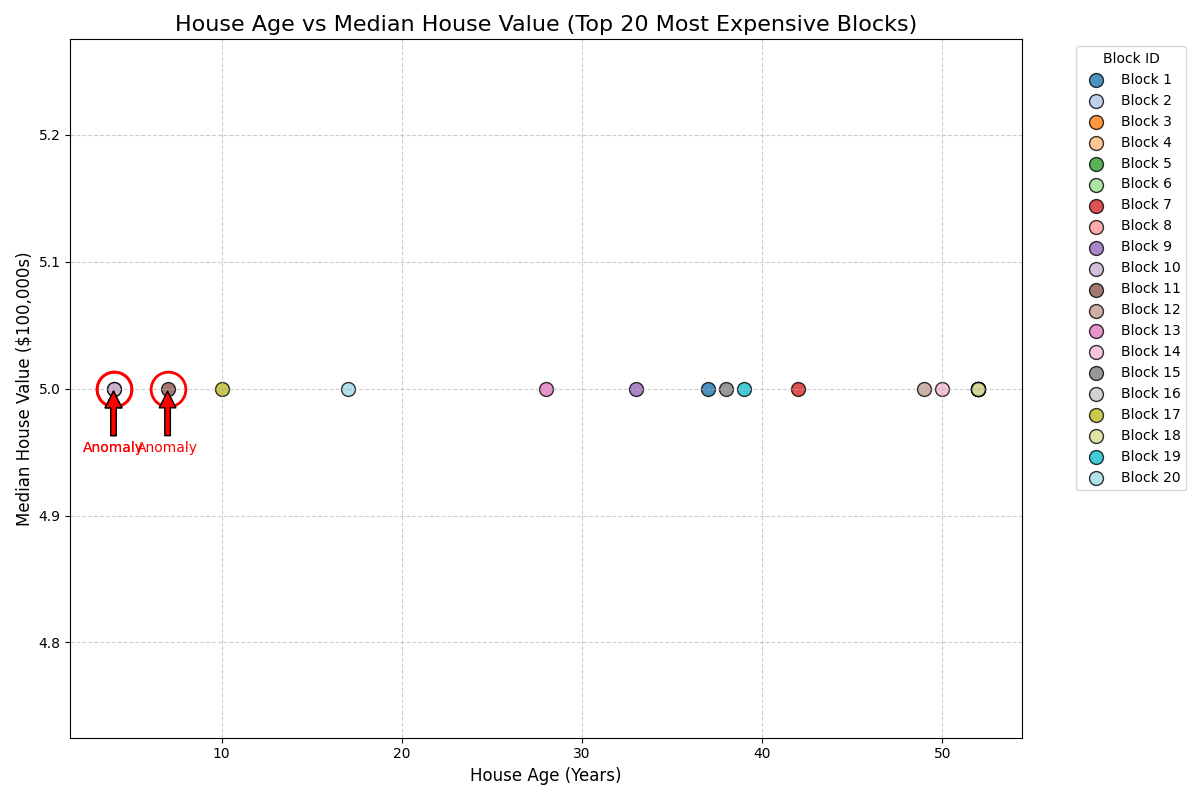

---

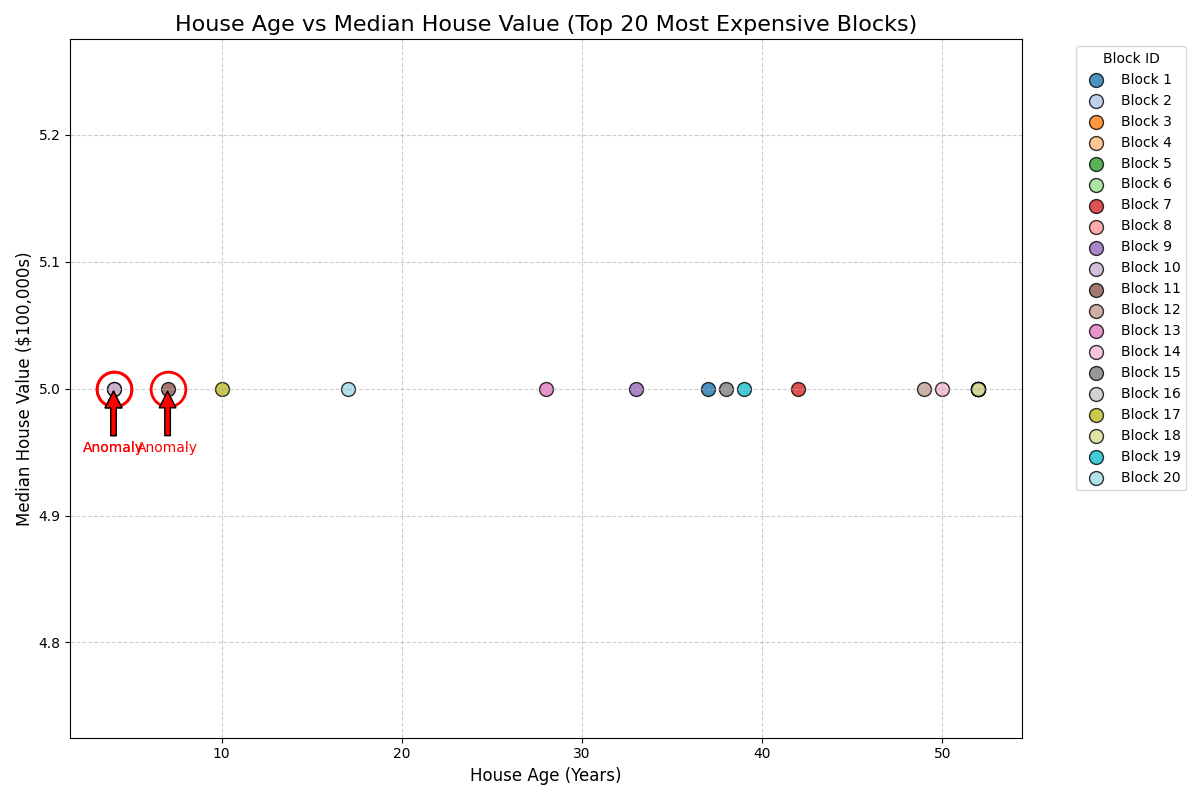

---

The scatterplot shows the relationship between House Age and Median House Value for the top 20 most expensive blocks in the dataset.

**Chart Details:**
*   **Filtering:** The dataset was sorted by `MedHouseVal` in descending order to select the top 20 blocks. Since the dataset has a cap on house values at 5.00001 (representing $500,000+), all top 20 points lie on this horizontal line.
*   **Coloring:** Each of the 20 blocks is represented by a unique color, as indicated in the legend on the right.
*   **Anomaly Detection:** Anomalies were defined statistically as points where the `HouseAge` is more than 1.5 standard deviations away from the mean age of this specific high-value group.
    *   The analysis identified two points with significantly lower House Age compared to the rest of the high-value blocks.
    *   These anomalies are highlighted with **red circles** and annotated with red arrows labeled "Anomaly".

This visualization effectively highlights that while the most expensive houses in this subset generally tend to be older (clustered between 30 and 55 years), there are a few distinct outliers that are significantly newer but command the same top-tier market value.

---

In [11]:
response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        "This dataset provides information on various blocks in Californina.",
        "Generate a scatterplot comparing the houses age with the median house value for the top-20 most expensive blocks.",
        "Use each black as a different color, and include a legend of what each color represents.",
        "Plot the age as the x-axis, and the median house value as the y-axis.",
        "In addition, point out on the graph which points could be anomalies? Circle the anomaly in red on the graph."
        "Then save the plot as an image file and display the image.",
        houses_file
    ],
    config=types.GenerateContentConfig(
        tools=[types.Tool(code_execution=types.ToolCodeExecution)]
    )
)

display_code_execution_result(response)

Moving forward with the data investigation, you can now analyze data variance in the dataset:

---

Variance of house price (15-25 years old): 1.0802898302341137


---

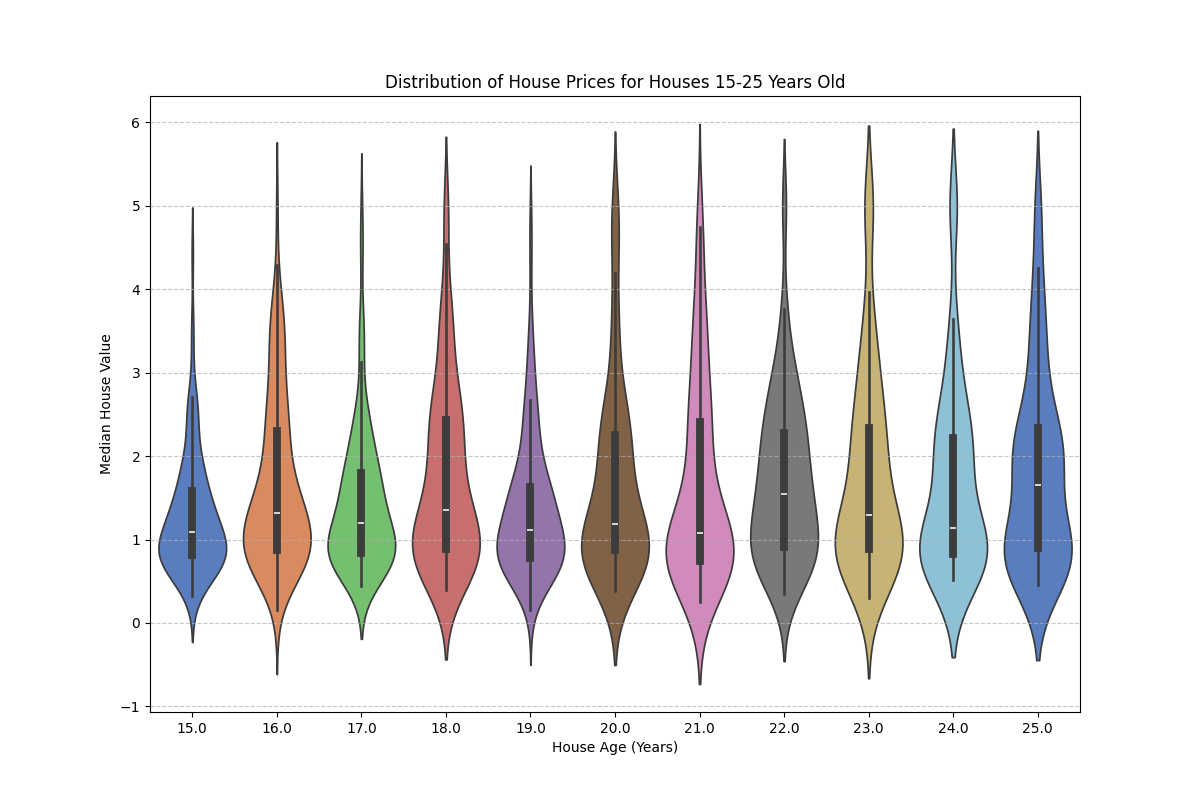

---

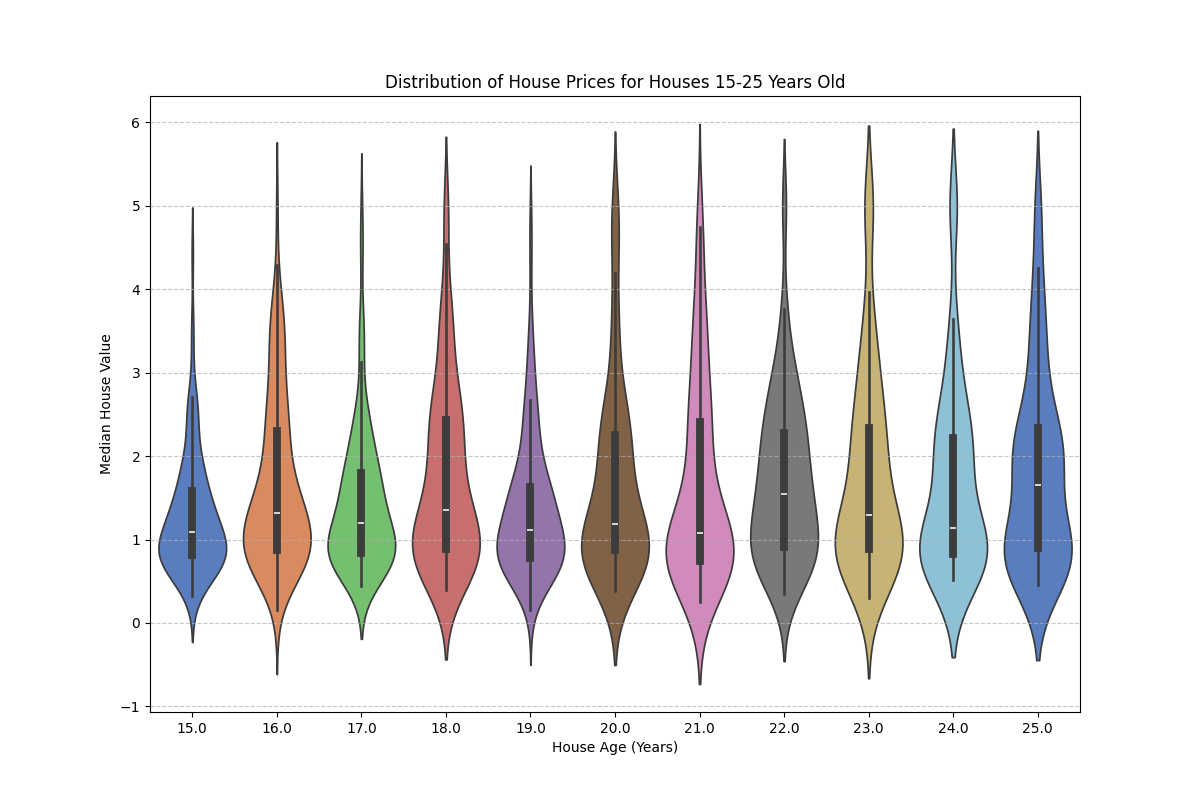

---

The calculated variance of the house price for houses between 15 and 25 years old is approximately **1.08**.

Below is the violin plot displaying the distribution of house prices for each age in that range:

![Violin Plot](output_2025-11-23-18-30-39-853198.png)

The code used to generate this analysis and plot is:

```python
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('input_file_0.csv')

# Filter for houses between 15 and 25 years old (inclusive)
filtered_df = df[(df['HouseAge'] >= 15) & (df['HouseAge'] <= 25)]

# Calculate the variance of the house price for this subset
price_variance = filtered_df['MedHouseVal'].var()
print(f"Variance of house price (15-25 years old): {price_variance}")

# Plot the violin plot
plt.figure(figsize=(12, 8))
sns.violinplot(data=filtered_df, x='HouseAge', y='MedHouseVal', palette="muted")
plt.title('Distribution of House Prices for Houses 15-25 Years Old')
plt.xlabel('House Age (Years)')
plt.ylabel('Median House Value')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Save the plot
output_filename = 'house_age_variance_violinplot.png'
plt.savefig(output_filename)
plt.show()
```

---

In [12]:
response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        "This dataset provides information on various blocks in Californina.",
        "Calculate the variance of the house price for houses between 15 and 25 Years old",
        "Plot the variance using a violinplot",
        "I would like you to use the x-axis for the house age, and house price for the y-axis",
        "Then save the plot as an image file and display the image.",
        houses_file
    ],
    config=types.GenerateContentConfig(
        tools=[types.Tool(code_execution=types.ToolCodeExecution)]
    )
)

display_code_execution_result(response)

Here is another example - Calculating repeated letters in a word (a common example where LLM sometimes struggle to get the result).

In [13]:
response = client.models.generate_content(
    model=MODEL_ID,
    contents="Calculate how many letter r in the word strawberry and show the code used to do it",
    config=types.GenerateContentConfig(
        tools=[types.Tool(code_execution=types.ToolCodeExecution)]
    )
)

In [14]:
display_code_execution_result(response)

---

3


---

There are **3** "r"s in the word strawberry.

Here is the Python code used to calculate it:

```python
word = "strawberry"
count = word.count("r")
print(count)
```

---

## Chat

It works the same when using a `chat`, which allows you to have multi-turn conversations with the model. You can set the `system_instructions` as well, which allows you to further steer the behavior of the model.

In [15]:
system_instruction = """
  You are an expert software developer and a helpful coding assistant.
  You are able to generate high-quality code in any programming language.
"""

chat = client.chats.create(
    model=MODEL_ID,
    config=types.GenerateContentConfig(
        system_instruction=system_instruction,
        tools=[types.Tool(code_execution=types.ToolCodeExecution)],
    ),
)

This time, you're going to ask the model to use a [Bogo-sort](https://en.wikipedia.org/wiki/Bogosort) algorithm to sort a list of numbers.

In [16]:
response = chat.send_message("Run the bogo-sort algorithm with this list of numbers as input until it is sorted: [2,34,1,65,4]")
display_code_execution_result(response)

---

Sorted List: [1, 2, 4, 34, 65]
Total Attempts: 9


---

I ran the **Bogo-sort** algorithm on your list. Here are the results:

*   **Input:** `[2, 34, 1, 65, 4]`
*   **Sorted Result:** `[1, 2, 4, 34, 65]`
*   **Attempts Required:** 9

**Note:** Since Bogo-sort relies on random shuffling, the number of attempts (9) was purely due to chance. The average expected number of attempts for a list of 5 numbers is $5!$ (120), so this specific run was actually quite lucky!

---

This code seems satisfactory, as it performs the task. However, you can further update the code by sending the following message below the model so that it can mitigate some of the randomness.

In [17]:
response = chat.send_message("Run an alternate implementation of the bogo-sort algorithm with the same input")
display_code_execution_result(response)

response = chat.send_message("How many iterations did it take this time? Compare it with the first try.")
display_code_execution_result(response)

---

Sorted List: [1, 2, 4, 34, 65]
Total Attempts: 52


---

Here is an alternate implementation using the **Bozo Sort** algorithm.

While standard **Bogo Sort** reshuffles the entire list every time, **Bozo Sort** picks two indices at random and swaps them. It is similarly inefficient but technically a different algorithmic approach to the "random check" strategy.

*   **Input:** `[2, 34, 1, 65, 4]`
*   **Sorted Result:** `[1, 2, 4, 34, 65]`
*   **Attempts Required:** 52

### The Code
```python
import random

def is_sorted(arr):
    """Checks if the list is sorted."""
    return all(arr[i] <= arr[i+1] for i in range(len(arr) - 1))

def bozo_sort(arr):
    """
    Bozo Sort: Swaps two random elements until sorted.
    """
    attempts = 0
    n = len(arr)
    while not is_sorted(arr):
        # Pick two random distinct indices
        i, j = random.sample(range(n), 2)
        
        # Swap them
        arr[i], arr[j] = arr[j], arr[i]
        attempts += 1
        
    return arr, attempts

data = [2, 34, 1, 65, 4]
bozo_sort(data)
```

---

In this specific run, the comparison is as follows:

*   **First Try (Bogo Sort):** 9 iterations
*   **Second Try (Bozo Sort):** 52 iterations

The second implementation took **43 more iterations** (about 5.7 times as many) as the first one.

### Why the difference?
Since both algorithms rely entirely on randomness, this variance is expected. 

For a list of 5 unique numbers, there are $5!$ (120) possible permutations. 
*   **Statistical Average:** You would normally expect it to take about **120 attempts** to sort this list randomly.
*   **Your Results:** Both of your runs (9 and 52) were actually quite "lucky" and finished significantly faster than the mathematical average. 

If you were to run them again, the results could easily flip, with one potentially taking hundreds of attempts.

---

Try running the previous cell multiple times and you'll see a different number of iterations, indicating that the Gemini API indeed ran the code and obtained different results due to the nature of the algorithm.

## Multimodal prompting

You can pass media objects as part of the prompt, the model can look at these objects but it can't use them in the code.

In this example, you will interact with Gemini API, using code execution, to run simulations of the [Monty Hall Problem](https://en.wikipedia.org/wiki/Monty_Hall_problem).

In [18]:
! curl -o montey_hall.png https://upload.wikimedia.org/wikipedia/commons/thumb/3/3f/Monty_open_door.svg/640px-Monty_open_door.svg.png

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 24719  100 24719    0     0   135k      0 --:--:-- --:--:-- --:--:--  135k


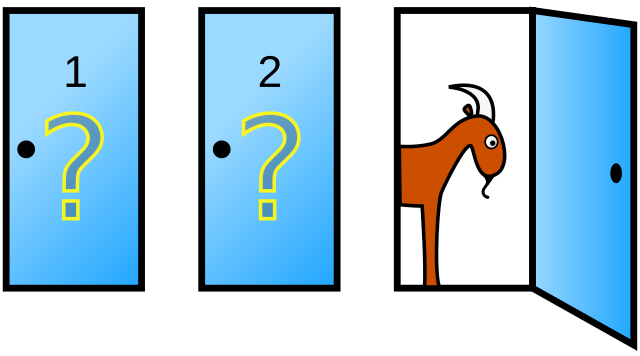

In [19]:
import PIL
montey_hall_image = PIL.Image.open("montey_hall.png")
montey_hall_image

---

Results after 1000 trials:
Wins by Staying: 320 (32.0%)
Wins by Switching: 680 (68.0%)


---

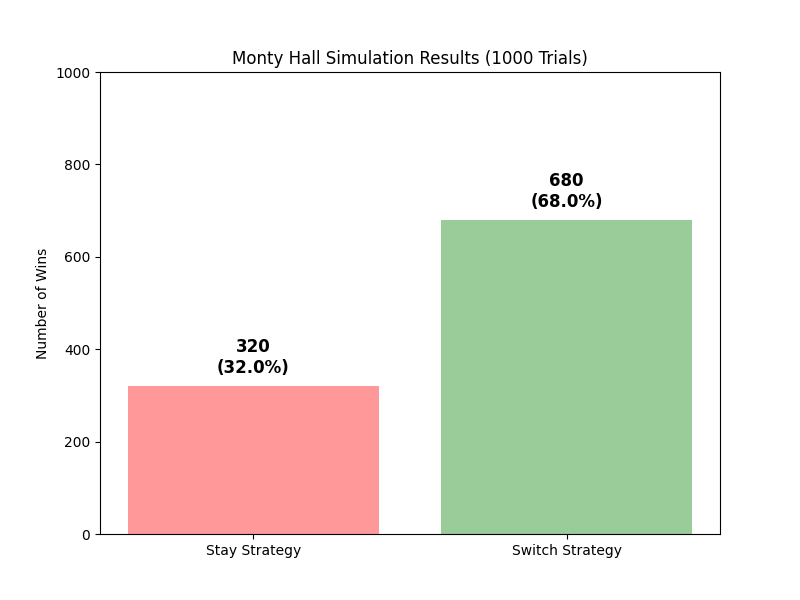

---

The simulation makes the answer extremely clear. You should **switch**.

In our 1,000 trials:
*   **Staying** won ~33% of the time (roughly 1 in 3).
*   **Switching** won ~67% of the time (roughly 2 in 3).

### Why does the math work this way?

The simulation exposes the logic that is often hard to visualize:

1.  **When you first pick a door**, you have a **1/3** chance of picking the car and a **2/3** chance of picking a goat.
2.  **If you picked the Car (1/3 chance):** Monty opens a goat door. If you switch, you lose. If you stay, you win.
3.  **If you picked a Goat (2/3 chance):** There is only one other goat door. Monty **must** open it (he can't open your door, and he can't reveal the car). That leaves the car behind the only closed door left. **If you switch, you win.**

Because you are twice as likely to start with a goat, you are twice as likely to win by switching.

---

In [20]:
prompt="""
    Run a simulation of the Monty Hall Problem with 1,000 trials.

    The answer has always been a little difficult for me to understand when people
    solve it with math - so run a simulation with Python to show me what the
    best strategy is.
"""
result = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        prompt,
        montey_hall_image
    ],
    config=types.GenerateContentConfig(
        tools=[types.Tool(code_execution=types.ToolCodeExecution)]
    )
)

display_code_execution_result(result)

## Streaming

Streaming is compatible with code execution, and you can use it to deliver a response in real time as it gets generated. Just note that successive parts of the same type (`text`, `executable_code` or `execution_result`) are meant to be joined together, and you have to stitch the output together yourself:

---

Simulation Results (1000 trials):
Wins when staying: 320 (32.0%)
Wins when switching: 680 (68.0%)


---

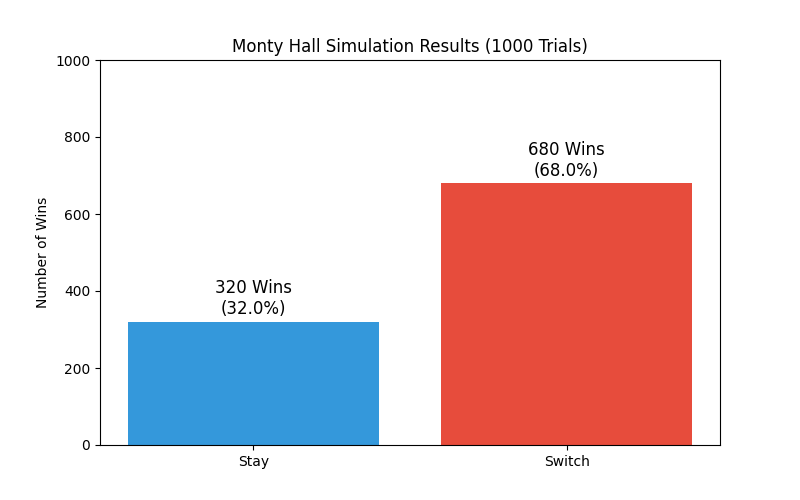

---

---

Here is

---

 the result of a 1,000-trial simulation.

### The

---

 Results
As the graph shows, switching is significantly better than staying.
*   **Staying** won **320

---

 times (32.0%)**.
*   **Switching** won **680 times (68.0

---

%)**.

### Why does this happen?
The math is often confusing because it feels like a 50/

---

50 choice once there are two doors left, but the simulation reveals the truth:

1.  **At the start

---

:** You have a **1/3** chance of picking the car and a **2/3** chance of picking a goat

---

.
2.  **If you picked the car (1/3 chance):** Monty opens a goat door. If

---

 you switch, you **lose**.
3.  **If you picked a goat (2/3 chance):**

---

 Monty *must* open the only other goat door. The only closed door left is the car. If you switch,

---

 you **win**.

Because you are more likely to start with a goat (2/3 chance), you are more

---

 likely to win by switching. The simulation proves that switching doubles your chances!

---

---

In [21]:
result = client.models.generate_content_stream(
    model=MODEL_ID,
    contents=[
        prompt,
        montey_hall_image
    ],
    config=types.GenerateContentConfig(
        tools=[types.Tool(code_execution=types.ToolCodeExecution)]
    )
)

for chunk in result:
  display_code_execution_result(chunk)

## Next Steps
### Useful API references:

Check the [Code execution documentation](https://ai.google.dev/gemini-api/docs/code-execution) for more details about the feature and in particular, the [recommendations](https://ai.google.dev/gemini-api/docs/code-execution?lang=python#code-execution-vs-function-calling) regarding when to use it instead of [function calling](https://ai.google.dev/gemini-api/docs/function-calling).

### Continue your discovery of the Gemini API

Please check other guides from the [Cookbook](https://github.com/google-gemini/cookbook/) for further examples on how to use Gemini and in particular [this example](../quickstarts/Get_started_LiveAPI_tools.ipynb) showing how to use the different tools (including code execution) with the Live API.

The [Search grounding](./Search_Grounding.ipynb) guide also has an example mixing grounding and code execution that is worth checking.

To see how code execution is used with Gemini 1.5, please take a look at the [legacy code execution example](https://github.com/google-gemini/cookbook/blob/gemini-1.5-archive/quickstarts/Code_Execution.ipynb).